Import all the necessary packages.

In [5]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
from fredapi import Fred

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 40)
pd.set_option("display.precision", 3)

# **TABLE 1 -  Cyclical Behaviour of the US Economy**

In [6]:
fred_key = '17193bb5d3d0af2508e249e344961fcf'
fred = Fred(api_key=fred_key)

Browsing the FRED website, I found the following series. `fred_codes` is a dictionary that maps each variable (key) to its associated FRED code (value). Then, a new empty dataframe `df` is created. By passing the function `get_fred_data`, each series in the dictionary is imported from the FRED website and consequently added to `df` as a new variable.

In [7]:
def get_fred_data(code):
    return fred.get_series(code, frequency = 'q')

fred_codes = {'GNP' : 'GNP',
              'CND' : 'PCND',
              'CD' : 'PCDG',
              'AVG_H' : 'AWHNONAG',
              'AVG_W' : 'AHETPI'}

df = pd.DataFrame()

for var in fred_codes.keys():
    df[var] = get_fred_data(fred_codes[var])

In [8]:
# this is what the dataframe looks like
df.head()

,GNP,CND,CD,AVG_H,AVG_W
1939-01-01,NaN,NaN,NaN,NaN,NaN
1939-04-01,NaN,NaN,NaN,NaN,NaN
1939-07-01,NaN,NaN,NaN,NaN,NaN
1939-10-01,NaN,NaN,NaN,NaN,NaN
1940-01-01,NaN,NaN,NaN,NaN,NaN


The `df` dataframe contains values for `GNP`, `CND` and `CD` starting from 1947-01-01, while the columns `avg_h` and `avg_w` start from 1964-01-01. For this reason, I decided to omit the rows with NA values. This yield a balanced `df` that starts from 1964-01-01.

In [9]:
df = df.dropna() # drop rows with NA
df.head()

,GNP,CND,CD,AVG_H,AVG_W
1964-01-01,674.880,148.651,57.995,38.4,2.50
1964-04-01,683.549,151.455,59.476,38.6,2.52
1964-07-01,697.079,154.877,61.378,38.5,2.55
1964-10-01,702.017,155.800,59.377,38.6,2.56
1965-01-01,723.225,157.760,64.915,38.7,2.59


With the above code chunk I obtained a dataframe containing _five_ out of the _eight_ variables I need to build the table.

Since no suitable data for `Total Hours Worked` and `Employment` was found on the FRED website, a [new source](https://www.bls.gov/productivity/tables/total-economy-hours-employment.xlsx) was imported from the Bureau of Labor Statistics. 
Since this file already contained data on both `Total Hours Worked` and `Employment` in the same sheet, I had to work a bit on the Excel file in order to extract from the main sheet the useful data, i.e. hours worked and emplyment only (I don't explain the passages beacuse I think it's not relevant, but if needed I'm available to show them). 

In [10]:
empl_hworked = pd.read_excel('total-economy-hours-employment.xlsx', sheet_name="Employment_THWorked")

# rename the columns
empl_hworked.rename(columns={'Total economy': 'tot_hours_worked'}, inplace=True)
empl_hworked.rename(columns={'Total economy.1': 'employment'}, inplace=True)
empl_hworked.rename(columns={'Sector': 'Year'}, inplace=True)

empl_hworked = empl_hworked[8:] # the first rows inlcuded descriptions and NA values, so I removed them

In [11]:
# change the data type from string to integer
empl_hworked['tot_hours_worked'].astype(float)
empl_hworked['employment'].astype(float)

empl_hworked.head(4)

,Year,tot_hours_worked,employment
8,1948 Q1,124.151,63.292
9,1948 Q2,124.43,63.143
10,1948 Q3,125.811,64.119
11,1948 Q4,125.348,64.064


The `Year` columns is a bit "troublesome", in the sense that it has the notation "YYYY QQ". Nothing that cannot be fixed, of course, but in this case I think it's unnecessary to clean the column in this way. In fact, I already have the `df` dataframe which contains a column for the time. In light of this, my idea is to simply add the columns `tot_hours_worked` and `employment` to the `df` dataframe, considering data _from 1964-01-01 only_, as above.



In [12]:
empl_hworked = empl_hworked.query("  Year >= '1964 Q1'   ")
empl_hworked.head(4)

,Year,tot_hours_worked,employment
72,1964 Q1,142.442,74.741
73,1964 Q2,143.997,75.143
74,1964 Q3,144.699,75.661
75,1964 Q4,145.716,76.044


In [13]:
# add the two columns to the df dataframe
df['Tot_Hours_Worked'] = empl_hworked['tot_hours_worked'].values
df['Employment'] = empl_hworked['employment'].values

# they are not added as numerical data types, so let's convert them
df['Tot_Hours_Worked'] = pd.to_numeric(df['Tot_Hours_Worked'], errors = 'coerce')
df['Employment'] = pd.to_numeric(df['Employment'], errors='coerce')

# double check the new data types
print(df.dtypes)

# take a look at the new df!
df.tail()

GNP                 float64
CND                 float64
CD                  float64
AVG_H               float64
AVG_W               float64
Tot_Hours_Worked    float64
Employment          float64
dtype: object


,GNP,CND,CD,AVG_H,AVG_W,Tot_Hours_Worked,Employment
2022-01-01,24929.184,3659.310,2183.860,34.1,26.99,288.590,166.065
2022-04-01,25456.409,3771.878,2181.760,34.1,27.40,289.057,167.375
2022-07-01,25885.432,3792.740,2195.833,34.0,27.75,291.335,168.554
2022-10-01,26289.489,3799.633,2180.382,33.9,28.09,291.575,169.472
2023-01-01,26592.668,3823.823,2259.535,34.0,28.40,293.909,170.677


### **From nominal to real**

The data imported from FRED don't have the word "`real`" in the description, so I deduced they are nominal. For this reason, it is necessary to convert them from nominal to real. The data need to be converted are: `GNP`, `CND`, `CD`, `AVG_W`. I didn't directly use real series because I didn't manage to find real series that covered several decades until the most recent ones, so my idea is to import the nominal ones and then apply the conversion through the CPI.

A way to do it is through the CPI index.
- From this [link](https://www.dallasfed.org/research/basics/nominal), that's the formula:

![alt text](cpi_formula.png "Title")

- The [CPI file](https://fred.stlouisfed.org/series/CPIAUCSL#0) comes from the FRED website: instead of acquiring it via the API, I modified the reference date because it was 1982 but I wanted a more recent year (2012). Thus I modified the settings from the website adding 2012 as the reference year and then downloaded it.

- [This video](https://www.youtube.com/watch?v=1Nf2i3gXCKA&ab_channel=tutor2u) was also helpful, especially for including the $/100$ at the denominator.

In [14]:
cpi = pd.read_excel('CPI.xls', index_col = 0)
cpi.rename(columns = {'CPIAUCSL_NBD20120101' : 'ind'}, inplace = True)

In [15]:
nominal = ['GNP', 'CND', 'CD', 'AVG_W']
df[nominal] = df[nominal].apply(lambda x: x/(cpi.ind/100))

### **Retrieve the last missing variable: productivity**

In this exercise `productivity` is computed as: $\frac{GNP}{L}$

In [16]:
df['Productivity'] = (df.GNP*1e09) / (df.Employment*1e06)

In [17]:
# see the complete dataset!
df.head()

,GNP,CND,CD,AVG_H,AVG_W,Tot_Hours_Worked,Employment,Productivity
1964-01-01,4981.980,1097.345,428.120,38.4,18.455,142.442,74.741,66656.594
1964-04-01,5037.831,1116.240,438.345,38.6,18.573,143.997,75.143,67043.248
1964-07-01,5125.965,1138.887,451.343,38.5,18.751,144.699,75.661,67749.109
1964-10-01,5138.558,1140.410,434.622,38.6,18.738,145.716,76.044,67573.489
1965-01-01,5277.439,1151.189,473.691,38.7,18.899,147.472,76.437,69042.991


### **Log transform** 

In [18]:
df = df.apply(lambda x: np.log(x))
df

,GNP,CND,CD,AVG_H,AVG_W,Tot_Hours_Worked,Employment,Productivity
1964-01-01,8.514,7.001,6.059,3.648,2.915,4.959,4.314,11.107
1964-04-01,8.525,7.018,6.083,3.653,2.922,4.970,4.319,11.113
1964-07-01,8.542,7.038,6.112,3.651,2.931,4.975,4.326,11.124
1964-10-01,8.545,7.039,6.074,3.653,2.931,4.982,4.331,11.121
1965-01-01,8.571,7.049,6.161,3.656,2.939,4.994,4.336,11.142
...,...,...,...,...,...,...,...,...
2022-01-01,9.902,7.984,7.468,3.529,3.074,5.665,5.112,11.698
2022-04-01,9.900,7.991,7.443,3.529,3.066,5.667,5.120,11.688
2022-07-01,9.904,7.983,7.436,3.526,3.065,5.674,5.127,11.684
2022-10-01,9.909,7.975,7.419,3.523,3.067,5.675,5.133,11.684


### **Extract Fluctuations**

The next step is to extract from the variables `trend` and `cycle` components. A way to do it is by means of `HP Filters`.

The following function takes the original dataframe as argument and outputs two dataframes: one containing trends, the other containing cyclical components.

In [19]:
def trend_extractor(original_df):
    
    # create two empty dataframes, one for trends and the other one for cycles
    df_cycle = pd.DataFrame()
    df_trend = pd.DataFrame()
    
    
    for var in list(original_df.columns.values):
        cycle, trend = sm.tsa.filters.hpfilter(original_df[var])
        df_cycle[var] = cycle 
        df_trend[var] = trend 
    
    return df_cycle, df_trend

In [20]:
# apply the function to the df
df_cycle, df_trend = trend_extractor(df)

# take a look at the cyclical df
df_cycle.head(3)

,GNP,CND,CD,AVG_H,AVG_W,Tot_Hours_Worked,Employment,Productivity
1964-01-01,-0.015,-0.023,-0.031,-0.010,-0.007,-0.014,-0.003,-0.012
1964-04-01,-0.016,-0.016,-0.020,-0.004,-0.004,-0.009,-0.005,-0.011
1964-07-01,-0.011,-0.005,-0.003,-0.005,0.002,-0.011,-0.005,-0.006


Let's have a glance at how these components look like.

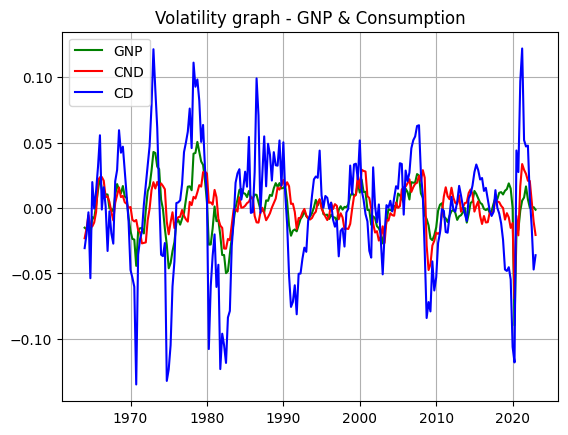

In [21]:
fig, ax = plt.subplots()

plt.plot(df_cycle.index, df_cycle.GNP, 'g-', label = 'GNP')
plt.plot(df_cycle.index, df_cycle.CND, 'r-', label='CND')
plt.plot(df_cycle.index, df_cycle.CD, 'b-', label='CD')

plt.grid()
plt.title('Volatility graph - GNP & Consumption')
plt.legend()

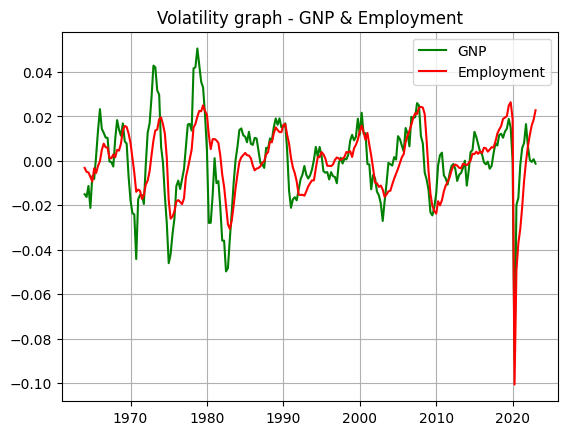

In [22]:
fig, ax = plt.subplots()

plt.plot(df_cycle.index, df_cycle.GNP, 'g-', label = 'GNP')
plt.plot(df_cycle.index, df_cycle.Employment, 'r-', label='Employment')

plt.grid()
plt.title('Volatility graph - GNP & Employment')
plt.legend()

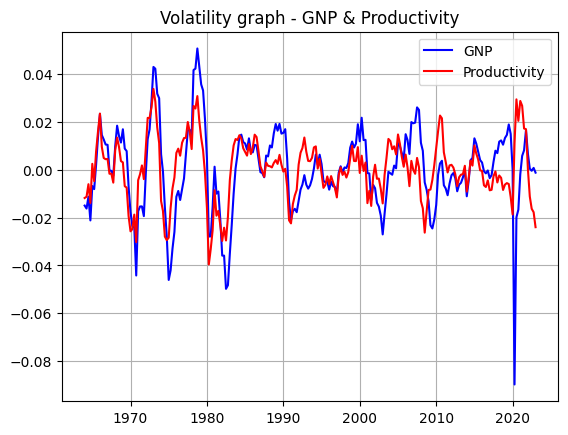

In [23]:
fig, ax = plt.subplots()

plt.plot(df_cycle.index, df_cycle.GNP, 'b-', label = 'GNP')
plt.plot(df_cycle.index, df_cycle.Productivity, 'r-', label='Productivity')

plt.grid()
plt.title('Volatility graph - GNP & Productivity')
plt.legend()

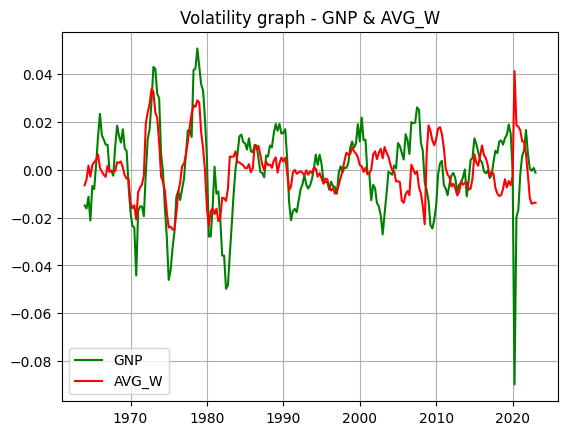

In [24]:
fig, ax = plt.subplots()

plt.plot(df_cycle.index, df_cycle.GNP, 'g-', label = 'GNP')
plt.plot(df_cycle.index, df_cycle.AVG_W, 'r-', label='AVG_W')

plt.grid()
plt.title('Volatility graph - GNP & AVG_W')
plt.legend()

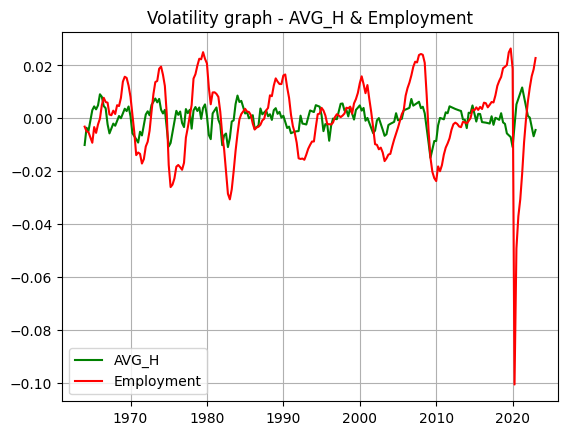

In [25]:
fig, ax = plt.subplots()

plt.plot(df_cycle.index, df_cycle.AVG_H, 'g-', label = 'AVG_H')
plt.plot(df_cycle.index, df_cycle.Employment, 'r-', label='Employment')

plt.grid()
plt.title('Volatility graph - AVG_H & Employment')
plt.legend()

### **Correlations: Table 1**

In [26]:
def cross_correlation(my_df, response): 
    
    cross_correlations = {}
    
    for var in list(my_df.columns.values):
       
        backward = sm.tsa.stattools.ccf(my_df[var][::-1], my_df[response][::-1], adjusted=False)[::-1]

        """The subsetting of backward ensures to extract only the cross-correlation from t-4
        to t-1. From forward we get the values from t to t+4"""
        
        forward = sm.tsa.stattools.ccf(my_df[var], my_df[response],  adjusted = False)
        
        ccf_output = np.r_[backward[-5:-1], forward[:5]] 
        cross_correlations[var] = ccf_output
        
    return cross_correlations

In [27]:
# apply the function to the GNP series
cross_correlations = cross_correlation(df_cycle, 'GNP')
cross_correlations

{'GNP': array([0.22400472, 0.4200247 , 0.6318014 , 0.80599098, 1.        ,
        0.80599098, 0.6318014 , 0.4200247 , 0.22400472]),
 'CND': array([-0.04548802,  0.13478365,  0.34077323,  0.47753948,  0.64680531,
         0.5827715 ,  0.54354672,  0.40496995,  0.27965338]),
 'CD': array([ 0.42895854,  0.57204353,  0.68968544,  0.77547055,  0.77552937,
         0.54253892,  0.36998184,  0.16038668, -0.0144228 ]),
 'AVG_H': array([ 0.20022072,  0.34183193,  0.46938984,  0.58110916,  0.57574373,
         0.44906273,  0.28361629,  0.13550708, -0.03242656]),
 'AVG_W': array([ 0.38177119,  0.4574497 ,  0.49113139,  0.48951102,  0.37559628,
         0.29034914,  0.17564214,  0.06026834, -0.05745619]),
 'Tot_Hours_Worked': array([-0.09370958,  0.06930426,  0.27609826,  0.48485033,  0.77261765,
         0.73975514,  0.6788922 ,  0.59105507,  0.472148  ]),
 'Employment': array([-0.17305634, -0.02806827,  0.17059735,  0.37813484,  0.68798288,
         0.70054505,  0.68412168,  0.63288222,  0.5423

In [28]:
corr_df = cross_correlation(df_cycle, 'GNP')

corr_df = pd.DataFrame(data = corr_df,
                               index = ['t-4', 't-3', 't-2', 't-1', 't', 't+1', 't+2', 't+3', 't+4']).T # T = transpose
corr_df

,t-4,t-3,t-2,t-1,t,t+1,t+2,t+3,t+4
GNP,0.224,0.420,0.632,0.806,1.000,0.806,0.632,0.420,0.224
CND,-0.045,0.135,0.341,0.478,0.647,0.583,0.544,0.405,0.280
CD,0.429,0.572,0.690,0.775,0.776,0.543,0.370,0.160,-0.014
AVG_H,0.200,0.342,0.469,0.581,0.576,0.449,0.284,0.136,-0.032
AVG_W,0.382,0.457,0.491,0.490,0.376,0.290,0.176,0.060,-0.057
Tot_Hours_Worked,-0.094,0.069,0.276,0.485,0.773,0.740,0.679,0.591,0.472
Employment,-0.173,-0.028,0.171,0.378,0.688,0.701,0.684,0.633,0.542
Productivity,0.497,0.599,0.662,0.663,0.576,0.300,0.083,-0.145,-0.308


In [29]:
# add the column of the standard deviation. The standard deviation is applied to the cycle_df
corr_df['st dev %'] = df_cycle.std()*100

# the added column is the rightmost one, so change the order to make the table equal to the one in the assignment
corr_df = corr_df[['st dev %','t-4', 't-3', 't-2', 't-1', 't', 't+1', 't+2', 't+3', 't+4']]
corr_df

,st dev %,t-4,t-3,t-2,t-1,t,t+1,t+2,t+3,t+4
GNP,1.751,0.224,0.420,0.632,0.806,1.000,0.806,0.632,0.420,0.224
CND,1.517,-0.045,0.135,0.341,0.478,0.647,0.583,0.544,0.405,0.280
CD,4.647,0.429,0.572,0.690,0.775,0.776,0.543,0.370,0.160,-0.014
AVG_H,0.451,0.200,0.342,0.469,0.581,0.576,0.449,0.284,0.136,-0.032
AVG_W,1.099,0.382,0.457,0.491,0.490,0.376,0.290,0.176,0.060,-0.057
Tot_Hours_Worked,1.715,-0.094,0.069,0.276,0.485,0.773,0.740,0.679,0.591,0.472
Employment,1.459,-0.173,-0.028,0.171,0.378,0.688,0.701,0.684,0.633,0.542
Productivity,1.296,0.497,0.599,0.662,0.663,0.576,0.300,0.083,-0.145,-0.308


#### **Answers to point B**

- _Consumption is smoother than output_

Looking at the standard deviation, durable consumption is more volatile than GNP, while non durable consumption is less volatile than GNP. 
The intuition here is that when bad times come, individuals reduce the expenses for durable consumption while consumption for non durable cannot be reduced too much, since it represents goods like food and other basic goods and services daily consumed.

Therefore, durable consumption is not smoother than output; non-durable consumption is smoother than output.

- _Volatility in GNP is similar in magnitude to volatility in total hours_

I confirm this fact. GNP's standard deviation is 1.75, while the analogue quantity for Tot_Hours_Worked is 1.71.

- _Volatility in employment is greater than volatility in average hours. Therefore most labour market adjustments operate on the extensive rather than intensive margin_ 

I confirm also this fact. Employment's standard deviation is 1.46, while the analogue quantity for AVG_H is 0.45. This means that labor market adjustments operate on the extensive margin: during changes due to the business cycles, people is more likely to exit and enter the labor market, rather than staying in the labor market and reduce whe working hours. 

- _Productivity is slightly pro-cyclical_ 

By looking at the values of the cross-correlation between GNP and Productivity, I can see that values from t-4 to t+2 are all positive, which would imply a pro-cyclical feature. Moreover, taking also into consideration the graph which shows volatility between GNP and Productivity, it's possible to spot a slightly lagged pattern, in which when the productivity increases, then slightly after the GNP increases.


- _Wages are less variable than productivity_

Once again, I found confirms in my analysis. In fact standard deviation for AVG_W is 1.098591 while standard deviation for Productivity is 1.29

- _There is no correlation between wages and output_

I had different findings. For both **table 1** and **table 2** I found a non-negligible correlation between wages and output. 

# **Table 2 - Business Cycle Statistics for the US Economy**

The variable population is loaded with the aim to obtain `per capita hours worked` as the ratio between total hours worked and population itself.

In [30]:
fred_codes = {
    'Y' : 'A939RX0Q048SBEA', # real GDP per capita
    'C' : 'A794RX0Q048SBEA', # real consumption per capita
    'w' : 'AHETPI',          # wage
    'I' : 'GPDI',            # investment, non per capita
    'G' : 'GCE',             # government expenditure, non per capita
    'pop': 'POPTHM',         # population
}

df2 = pd.DataFrame()

for var in fred_codes.keys():
    df2[var] = get_fred_data(fred_codes[var])

Dropping na values, the new cleaned `df2` will start from 1964-01-01.

In [31]:
df2 = df2.dropna()

Now let's upload data about `real interest rate`, with the aim to add it into the `df2`.

In [32]:
r_int_rate = pd.read_excel('rates.xls')
r_int_rate = r_int_rate.query(   " observation_date >= '1964-01-01' "   )

In [33]:
df2['r'] = r_int_rate['DFF'].values

Compute `N - hours worked per capita` as the ratio between `total hours worked` and number of people `employed`. These variables were already uploaded for rebuilding the first table!

In [34]:
df2['N'] = (df['Tot_Hours_Worked']*1e9) / (df['Employment']*1e06)

Note: N is a bit wrong, in the sense that according to this data a worker works, on average, ~1.000 hours per quarter, which is roughly 90 hours per week. I know this doesn't sound reasonable but it is the best I could come up with.

Compute `I - investment per capita`, starting from the overall investment and dividing for the population.

In [35]:
df2['I'] = (df2['I']*1e9) / (df2['pop']*1000)

Compute `Y/N` as the ratio.

In [36]:
df2['Y/N'] = df2['Y'] / df2['N']

Compute G per capita.

In [37]:
df2['G'] = (df2['G']*1e9) / (df2['pop']*1000)

In [38]:
df2 = df2[['Y', 'C', 'I', 'N', 'Y/N', 'w', 'G', 'r']]
df2.head()

,Y,C,I,N,Y/N,w,G,r
1964-01-01,20182.0,12179.0,578.537,1149.490,17.557,2.50,798.904,4.179
1964-04-01,20337.0,12355.0,576.937,1150.577,17.675,2.52,805.565,4.201
1964-07-01,20580.0,12537.0,585.839,1149.874,17.898,2.55,811.590,4.194
1964-10-01,20571.0,12529.0,595.963,1150.150,17.885,2.56,809.338,4.175
1965-01-01,21011.0,12773.0,654.075,1151.545,18.246,2.59,811.637,4.204


### **From nominal to real**

Y and C are already real.

In [39]:
nominal_2 = ['I', 'w', 'G']
df2[nominal_2] = df2[nominal_2].apply(lambda x: x/(cpi.ind/100))

In [40]:
cpi = pd.read_excel('CPI.xls', index_col = 0)
cpi.rename(columns = {'CPIAUCSL_NBD20120101' : 'ind'}, inplace = True)
df2

,Y,C,I,N,Y/N,w,G,r
1964-01-01,20182.0,12179.0,4270.776,1149.490,17.557,18.455,5897.532,4.179
1964-04-01,20337.0,12355.0,4252.087,1150.577,17.675,18.573,5937.101,4.201
1964-07-01,20580.0,12537.0,4307.960,1149.874,17.898,18.751,5968.019,4.194
1964-10-01,20571.0,12529.0,4362.278,1150.150,17.885,18.738,5924.115,4.175
1965-01-01,21011.0,12773.0,4772.848,1151.545,18.246,18.899,5922.590,4.204
...,...,...,...,...,...,...,...,...
2022-01-01,59836.0,42130.0,11242.668,1108.096,53.999,21.631,10377.002,1.951
2022-04-01,59688.0,42300.0,10831.694,1106.711,53.933,21.459,10368.459,2.933
2022-07-01,60080.0,42476.0,10599.737,1106.727,54.286,21.442,10400.604,3.101
2022-10-01,60376.0,42524.0,10684.639,1105.716,54.604,21.485,10468.514,3.827


### **Log-transform the dataframe.**

In [41]:
# create a dataframe called df2_log which doesn't include the real interest rate
df2_log = df2.iloc[:, :-1]
df2_log.head(2)

,Y,C,I,N,Y/N,w,G
1964-01-01,20182.0,12179.0,4270.776,1149.490,17.557,18.455,5897.532
1964-04-01,20337.0,12355.0,4252.087,1150.577,17.675,18.573,5937.101


In [42]:
# apply the logarithm to the dataframe df2_log
df2_log = df2_log.apply(lambda x: np.log(x))
df2_log.head(2)

,Y,C,I,N,Y/N,w,G
1964-01-01,9.913,9.407,8.360,7.047,2.865,2.915,8.682
1964-04-01,9.920,9.422,8.355,7.048,2.872,2.922,8.689


In [43]:
# add the column of the real interest rate
df2_log['r'] = df2['r']

### **Extract Fluctuations**

In [44]:
# apply the function to the df
df2_log_cycle, df2_log_trend = trend_extractor(df2_log)

# take a look at the cyclical df
df2_log_cycle.head(3)

,Y,C,I,N,Y/N,w,G,r
1964-01-01,-0.011,-0.012,-0.039,-1.987e-03,-0.009,-0.007,7.300e-03,0.272
1964-04-01,-0.013,-0.008,-0.054,-6.612e-04,-0.013,-0.004,8.038e-04,0.192
1964-07-01,-0.011,-0.003,-0.052,-8.895e-04,-0.010,0.002,-7.190e-03,0.083


## **Build Table 2**

Start by computing the Standard Deviation.

In [45]:
table2 = pd.DataFrame()

table2['Standard Deviation'] = df2_log_cycle.std()*100

Compute Relative Standard Deviation.

In [46]:
table2['Rel_std_dev'] = table2['Standard Deviation'] / table2.at['Y', 'Standard Deviation']

Compute the First Order Autocorrelation.

In [47]:
autocorrelations = {}

for var in df2_log_cycle.columns:
    autocorrelations[var] = df2_log_cycle[var].autocorr()

table2['Autocorrelations'] = autocorrelations.values()

Compute the Contemporaneous Correlatin with Output.

In [48]:
correlations = {}

for var in df2_log_cycle.columns:
    correlations[var] = df2_log_cycle['Y'].corr(df2_log_cycle[var])

correlations

table2['Correlations'] = correlations.values()

# Visualize the final **TABLE 2 - Business Cycle Statistics for the US Economy**

In [49]:
table2

,Standard Deviation,Rel_std_dev,Autocorrelations,Correlations
Y,1.569,1.000,0.771,1.000
C,1.410,0.899,0.719,0.887
I,6.590,4.201,0.833,0.873
N,0.074,0.047,0.708,0.468
Y/N,1.536,0.979,0.770,0.999
w,1.099,0.700,0.856,0.143
G,1.420,0.905,0.820,0.027
r,73.284,46.711,0.804,0.108


In [51]:
import dataframe_image as dfi

table2_styled = table2.style.background_gradient()

dfi.export(table2_styled,"mytable.png")

# **Questions of point C**:

 - _Consumption of non-durables is less volatile than output_. 
 
The answer I provided for question1 of pointB is valid here.

 - _Consumer durables are more volatile than output._ 
 
The answer I provided for question1 of pointB is valid here.

 - _Investment is three times more volatile than output_. 
 
 To asnwer this question I look at **table 2**, where I summarized standard deviations for GDP per capita and Investment per capita. The pattern is confirmed, as Investment (per capita) looks four times more volatile than output (per capita). I think the intuition to this pattern is that, as economic outlook turns uncertain or "negative times" are expected to arrive, consumers tend to be more risk averse and for this reason they may reduce their exposition to investments and keep liquidity uninvested.
 The idea is that investment decisions are influenced by the business cycle. During economic expansions output and income are extpected to grow, and both businesses and consumers (through savings) tend to increase their investment activities. Conversely, during economic contractions or recessions, investment tends to decline as perspectives are worse. 

 - _Government expenditures are less volatile than output._ 

Still looking at **table 2** I found the standard dev. of G per capita to be lower than the same quantity for Output per capita. So the pattern is confirmed, even though the difference is negligible in my data.

- _Total hours worked are about the same volatility as output._ 

To answer this I go back to **table 1** and also in this case I confirm the pattern from my data for which the volatility is about the same.

- _ Employment is as volatile as output, while hours per worker are much less volatile than output._

To answer this I go back to **table 1**. I found Employment slightly less volatile than output.
Then to compare the volatility of hours per worker and output, I look at **table 2** here I found that hours per worker is (a lot) more volatile than output. 

- _Labour productivity is less volatile than output_

To answer this question, I look at **table 2** and I see that they're on the same level of volatility, where productivity has a (ver) slightly lower st. dev

- _The real wage is much less volatile than output._

Looking at **table 2** I found the same pattern.